In [ ]:

import sys

command_str = '{sys.executable} -m pip install --upgrade wikipedia'.format(sys=sys)
print(command_str)
!{command_str}

In [ ]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [ ]:

%pprint
%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py
%run ../../load_magic/charts.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

dir()

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"


----
# Scrape the Data

In [4]:

import pandas as pd
%run ../../load_magic/storage.py
s = Storage()

# https://ourworldindata.org/covid-deaths
# https://twitter.com/Roshan_Karia/status/1257726938946449408
# Always get fresh data
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid_deaths_df = pd.read_csv(url).groupby('location').total_deaths.max().to_frame()
covid_deaths_df.index.name = 'Country'
covid_deaths_df.columns = ['Deaths']
s.store_objects(covid_deaths_df=covid_deaths_df)
covid_deaths_df.sample(5)

,Deaths
Country,
Pakistan,803
Burkina Faso,51
Mozambique,0
France,27425
Seychelles,0


In [5]:

try:
    temps_df = s.load_object('temps_df')
except:
    tables_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature'
    tables_list = get_page_tables(tables_url)
    temps_df = tables_list[0].copy()
    temps_df.columns = ['Country', 'Temperature']
    temps_df.set_index('Country', drop=True, inplace=True)
    temps_df.Temperature = temps_df.Temperature.map(lambda x: float(re.sub('−', '-', x)))
    s.store_objects(temps_df=temps_df)
temps_df.sample(5)

,Temperature
Country,
Peru,19.60
Niger,27.15
Liechtenstein,5.65
Iraq,21.40
South Korea,11.50


In [6]:

# Also then compare it population wise to any cold country
columns_list = ['Population']
country_populations_df = s.load_object('country_populations_df')[columns_list]
country_populations_df.sample(5)

,Population
Country,
São Tomé and Príncipe,201784
Peru,32131400
Austria,8902600
Congo,5518092
U.S. Virgin Islands (US),104578



----
# Merge the Data

In [7]:

'Singapore' in set(country_populations_df.index).intersection(set(covid_deaths_df.index)).intersection(set(temps_df.index))

True

In [8]:

merge_df = country_populations_df.merge(covid_deaths_df, left_index=True, right_index=True, suffixes=('_country', '_deaths'))
merge_df = merge_df.merge(temps_df, left_index=True, right_index=True, suffixes=('_merge', '_temps'))
merge_df['Deaths_per_Capita'] = merge_df.apply(lambda row_series: row_series.Deaths/row_series.Population, axis='columns')
merge_df.sample(5)

,Population,Deaths,Temperature,Deaths_per_Capita
Country,,,,
New Zealand,4979037,21,10.55,4.217683e-06
Tunisia,11722038,45,19.20,3.838923e-06
Libya,6871287,3,21.80,4.365994e-07
Senegal,16209125,23,27.85,1.418954e-06
Cape Verde,550483,2,23.30,3.633173e-06



----
## Compute the color list

In [ ]:

cold_war_list = ['Belgium', 'Canada', 'Denmark', 'France', 'Germany', 'Greece', 'Iceland', 'Italy', 'Luxembourg', 'Netherlands',
                 'Norway', 'Portugal', 'Spain', 'Turkey', 'United', 'Kingdom', 'USA']
us_aligned_list = ['Israel', 'Japan', 'South', 'Korea']
former_colonies_list = ['Australia', 'New Zealand']
neutral_industrialized_list = ['Austria', 'Ireland', 'Sweden', 'Switzerland']
first_world_list = cold_war_list + us_aligned_list + former_colonies_list + neutral_industrialized_list

In [ ]:

# https://www.nationsonline.org/oneworld/second_world.htm
second_world_list = s.load_csv('second_world_countries').Country.tolist()
second_world_list = list(set(second_world_list).intersection(set(merge_df.index)))

In [ ]:

def f(x):
    x = str(x)
    if x in first_world_list:
        return_value = 'First World'
    elif x in second_world_list:
        return_value = 'Second World'
    else:
        return_value = 'Third World'
    
    return return_value
merge_df['World_Label'] = merge_df.index.map(f)

In [ ]:

color_cycler = get_color_cycler(len(merge_df.World_Label.unique()))
color_dict = {}
for world_label, face_color_dict in zip(merge_df.World_Label.unique(), color_cycler()):
    face_color = face_color_dict['color']
    color_dict[world_label] = face_color
color_list = [color_dict[world_label] for world_label in df.World_Label]


----
# Plot the Data

In [10]:

import numpy as np

merge_df['Log_Deaths_per_Capita'] = merge_df.Deaths_per_Capita.map(lambda x: np.log(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:

%run ../../load_magic/charts.py
inf_nan_mask = get_inf_nan_mask(merge_df.Temperature.values, merge_df.Log_Deaths_per_Capita.values)
df = merge_df[pd.Series(inf_nan_mask, index=merge_df.index)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:417: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(grid, yhat, **kws)


Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\countries_by_average_temp.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\countries_by_average_temp.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\countries_by_average_temp.svg


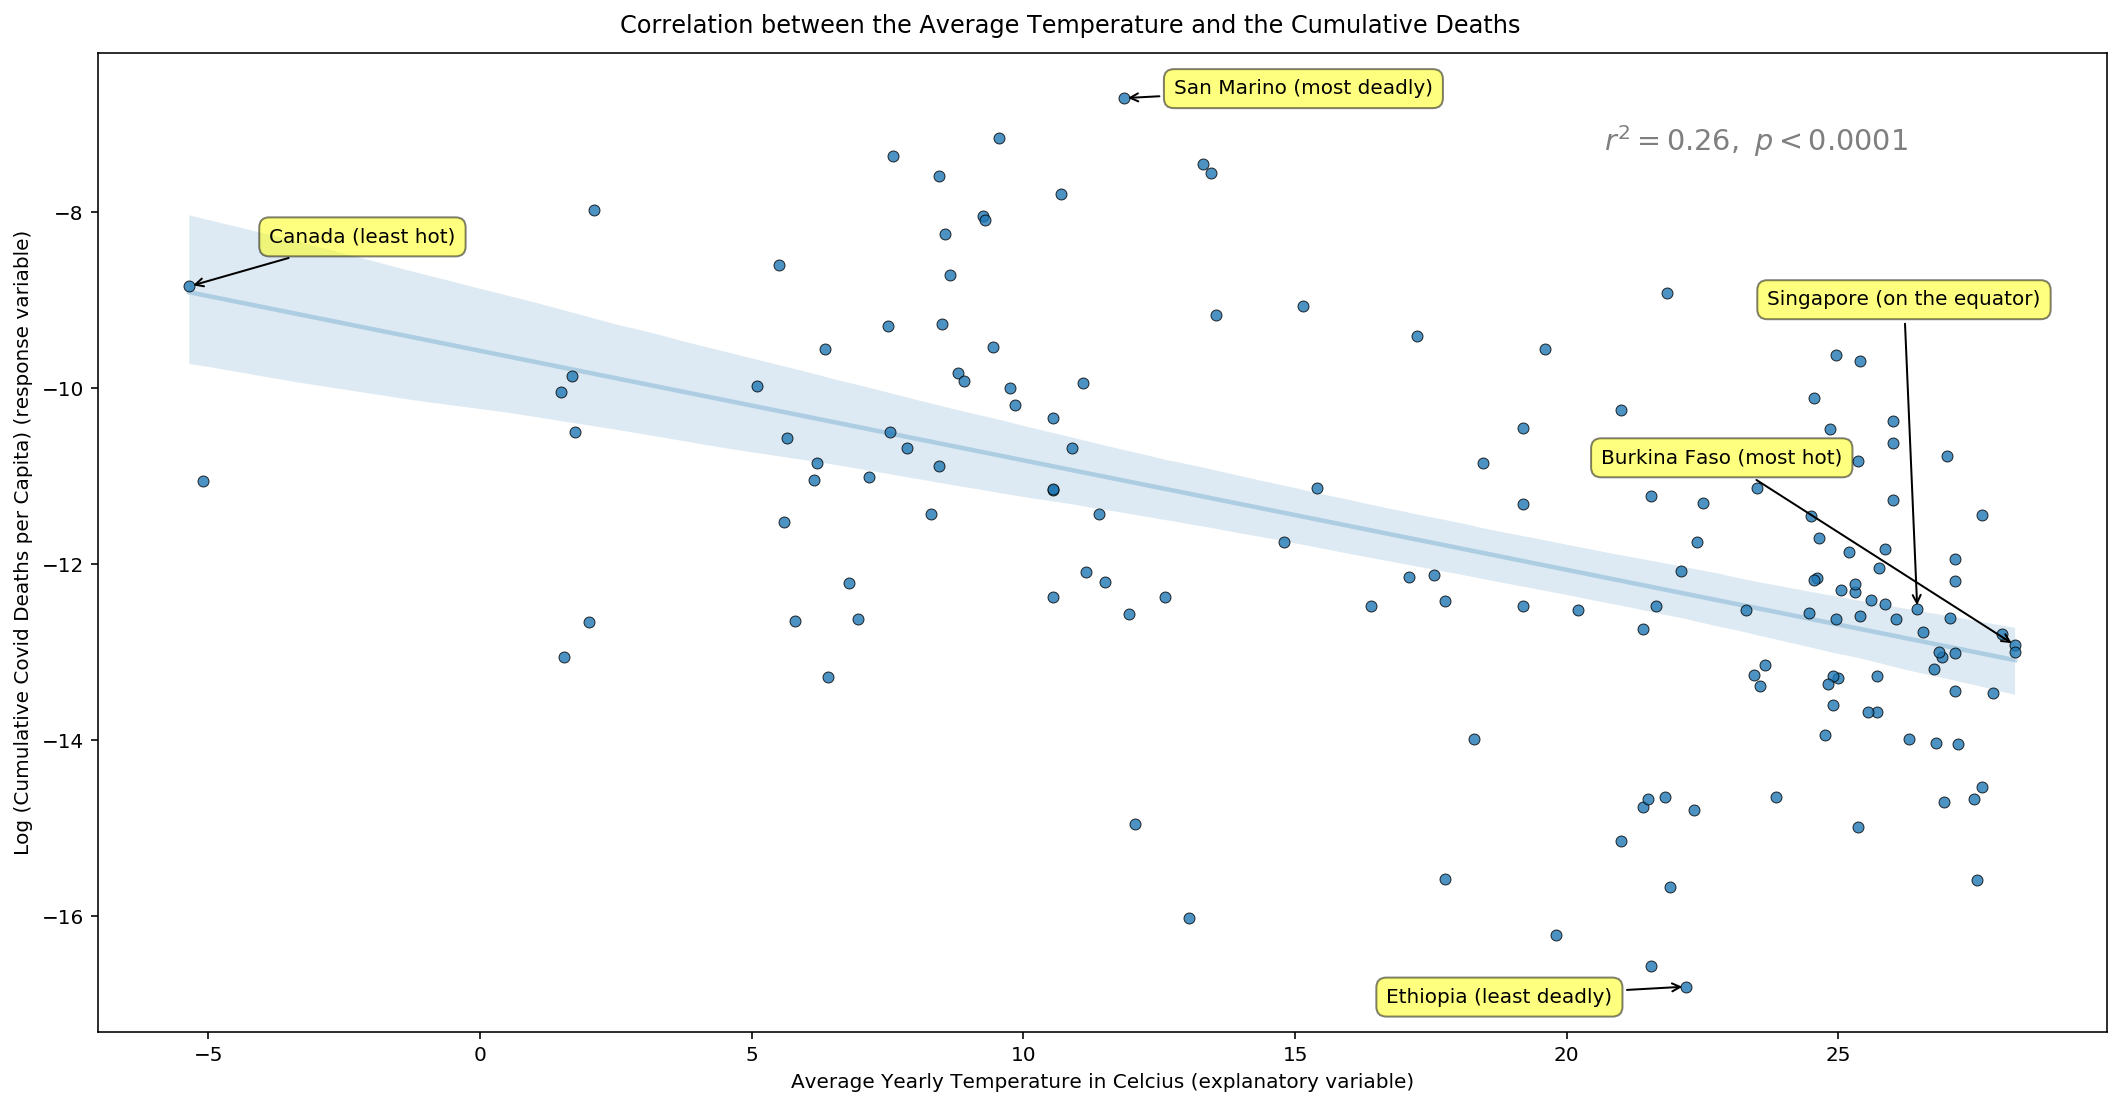

In [20]:

# https://twitter.com/Roshan_Karia/status/1257726938946449408
title_text = 'Correlation between the Average Temperature and the Cumulative Deaths'
fig = first_order_linear_scatterplot(df, 'Temperature', 'Log_Deaths_per_Capita',
                                     xlabel_str='Average Yearly Temperature in Celcius (explanatory variable)',
                                     ylabel_str='Log (Cumulative Covid Deaths per Capita) (response variable)',
                                     x_adj='hot', y_adj='deadly', title=title_text, idx_reference='Singapore',
                                     annot_reference='on the equator', aspect_ratio=18/9,
                                     least_x_xytext=(40, 20), most_x_xytext=(-207, 89),
                                     least_y_xytext=(-150, -10), most_y_xytext=(25, 0),
                                     reference_xytext=(-75, 150))
save_fig_as_various(fig, 'countries_by_average_temp', verbose=True)